In [26]:
import numpy as np
import scipy.sparse as sps
import h5py
from termcolor import colored

def decode_str(hdf5_str):
    return hdf5_str.tobytes().decode('utf-16')

# filename = 'data/Head-and-Neck_07.mat'
filename = 'Prostate_CK/Prostate_CK_04.mat'
# filename = 'Liver/Liver_01.mat'
f = h5py.File(filename)
patient_name = decode_str(f['patient']['Identifier'][:])
print(colored('Patient: ' + patient_name, 'blue'))



Patient: Prostate CK 04


In [28]:
class Beam:
    def __init__(self, i, n_beamlets, gantry, field):
        self.i = i
        self.n_beamlets = n_beamlets
        self.gantry = gantry
        self.field = field
    def __repr__(self):
        return 'Beam {:2d}, gantry at {:6.2f}°'.format(self.i, self.gantry)

    def draw_fluence(self, offset, fluence):
        self.fluence = self.field.copy()
        for i in range(self.field.shape[0]):
            for j in range(self.field.shape[1]):
                if self.field[i, j] > 0:
                    self.fluence[i, j] = fluence[offset + self.field[i, j] - 1] # -1 because MATLAB indices start in 1.
        
n_beams = int(f['patient']['Beams']['Num'][0][0])
print('Number of beams:', n_beams)
n_beamlets = [int(x) for x in f['patient']['Beams']['ElementIndex'][0]]
# n_beamlets = [int(x[0]) for x in f['patient']['Beams']['ElementIndex']]

print('Number of beamlets per beam:', n_beamlets)
beams = []
offset = 0
original_fluence = f['solutionX'][:].ravel()

for i in range(n_beams):
    gantry_angle = f[f['patient']['Beams']['BeamConfig']['Gantry'][i][0]][0][0]
    field = f[f['patient']['Beams']['BeamConfig']['Field'][i][0]][:]
    beam = Beam(i, n_beamlets[i], gantry_angle, field)
    beam.draw_fluence(offset, original_fluence)
    beams.append(beam)
    offset += n_beamlets[i]

for beam in beams:
    print(beam)

Number of beams: 25
Number of beamlets per beam: [99, 105, 86, 91, 106, 79, 103, 75, 88, 78, 112, 104, 68, 127, 113, 63, 136, 115, 80, 138, 112, 90, 134, 114, 121]
Beam  0, gantry at  66.20°
Beam  1, gantry at  58.30°
Beam  2, gantry at 281.90°
Beam  3, gantry at  78.10°
Beam  4, gantry at 298.20°
Beam  5, gantry at  90.00°
Beam  6, gantry at 298.20°
Beam  7, gantry at 293.50°
Beam  8, gantry at 281.60°
Beam  9, gantry at 258.40°
Beam 10, gantry at 309.60°
Beam 11, gantry at  54.60°
Beam 12, gantry at  95.90°
Beam 13, gantry at  20.90°
Beam 14, gantry at  43.10°
Beam 15, gantry at 264.10°
Beam 16, gantry at  21.70°
Beam 17, gantry at  43.10°
Beam 18, gantry at 288.00°
Beam 19, gantry at 347.90°
Beam 20, gantry at 316.90°
Beam 21, gantry at 293.80°
Beam 22, gantry at  12.10°
Beam 23, gantry at 309.60°
Beam 24, gantry at  20.60°


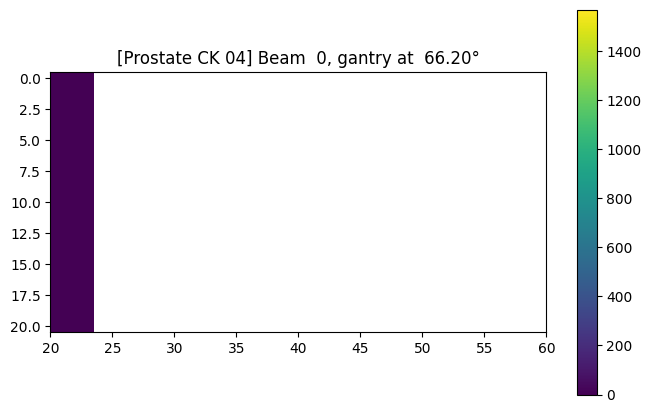

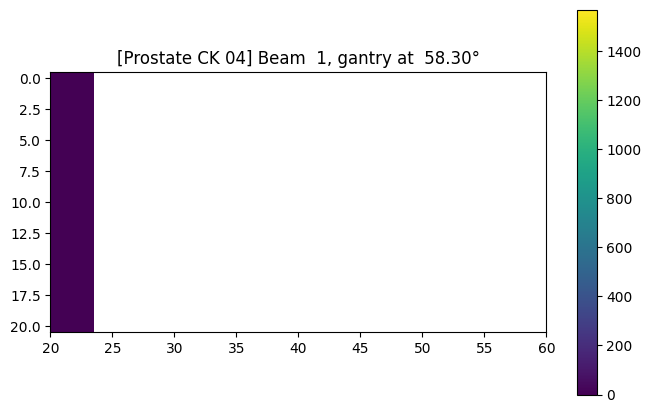

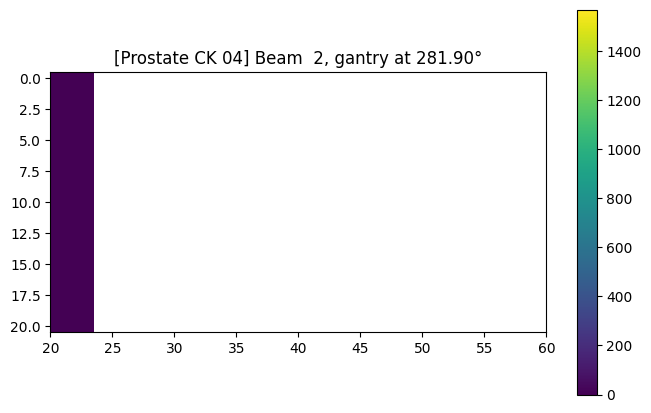

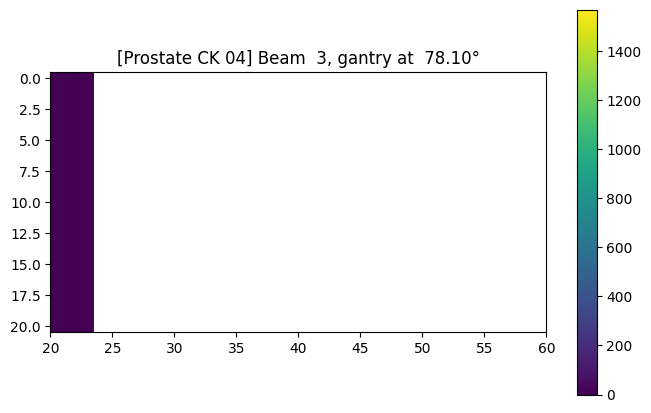

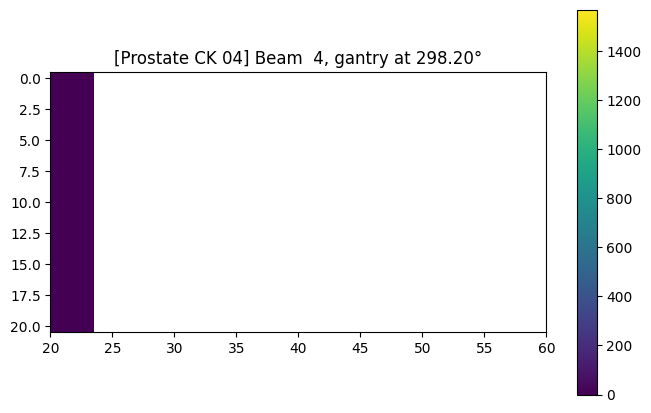

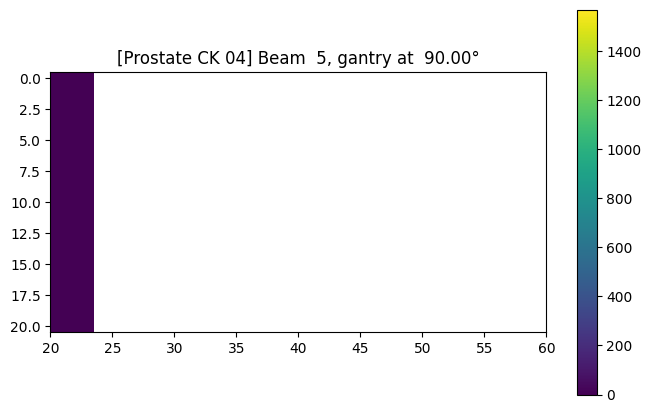

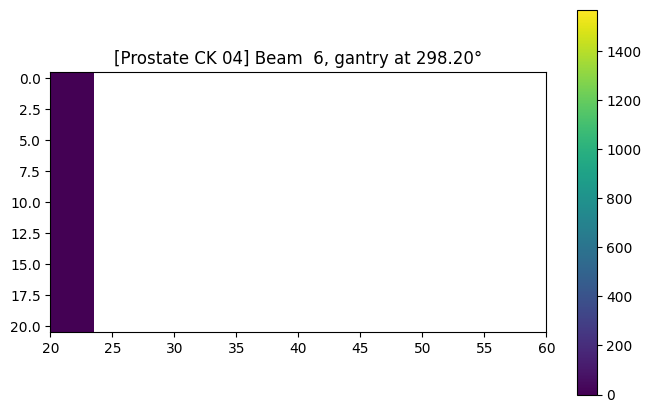

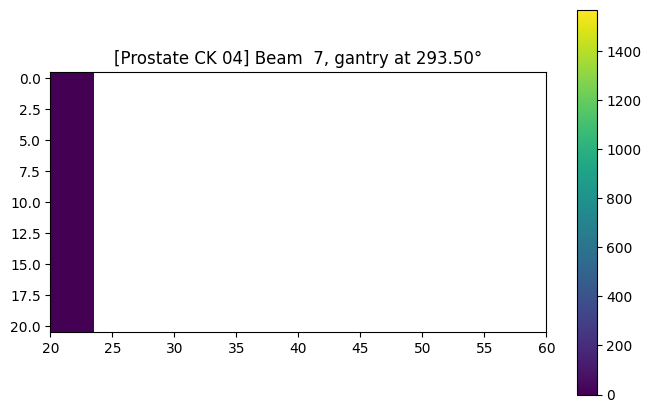

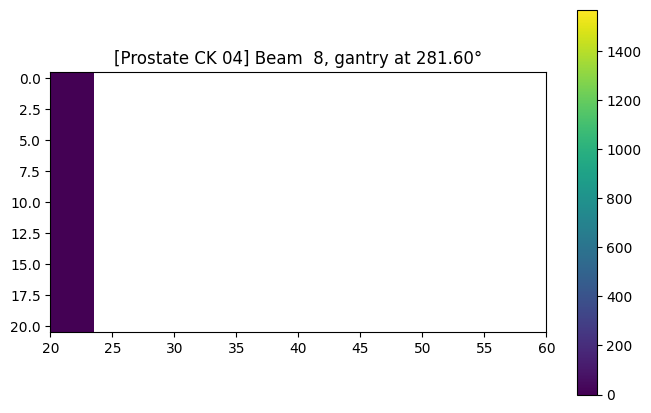

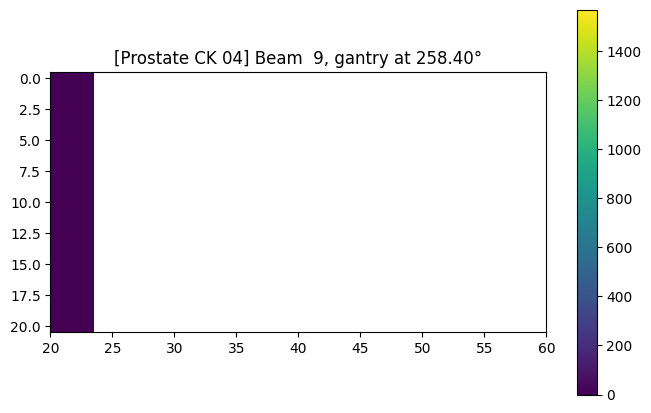

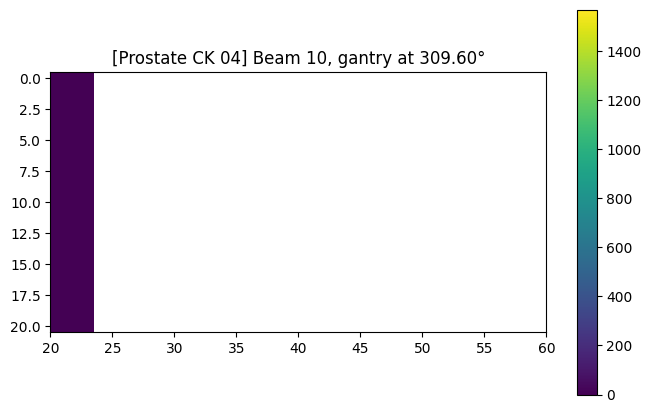

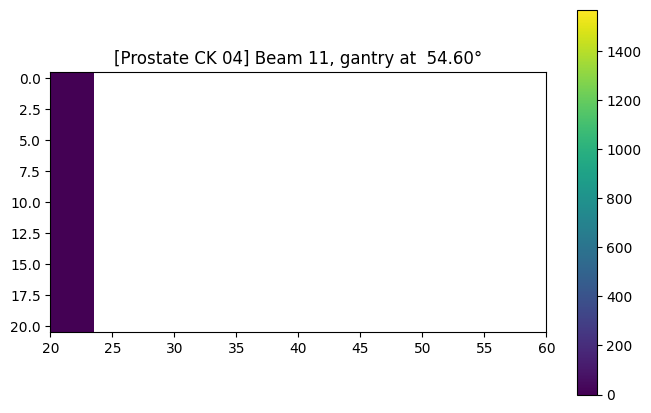

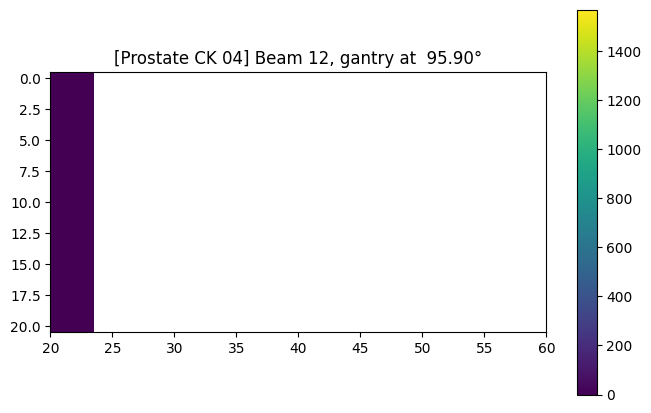

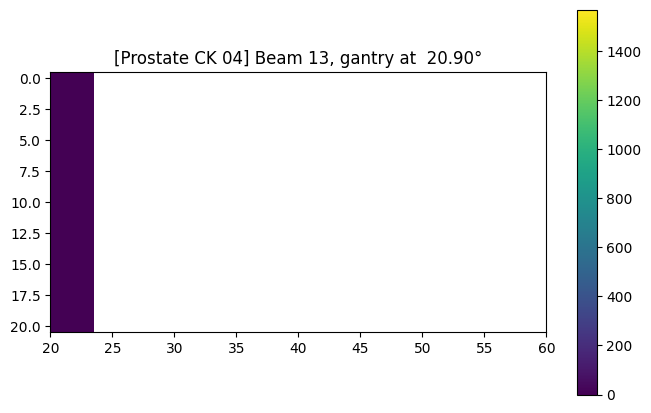

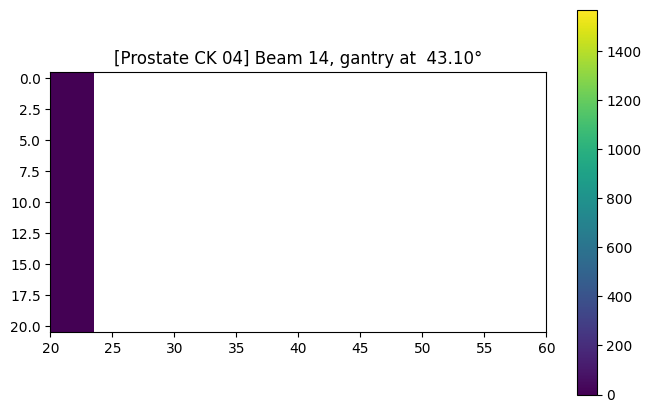

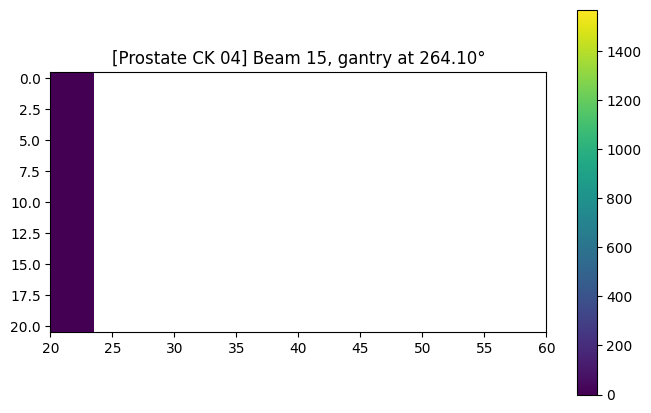

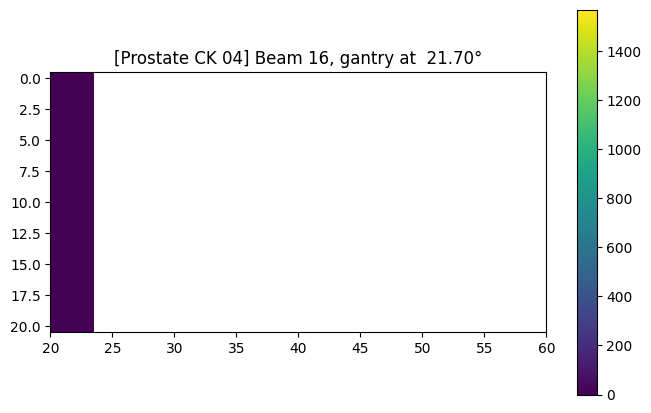

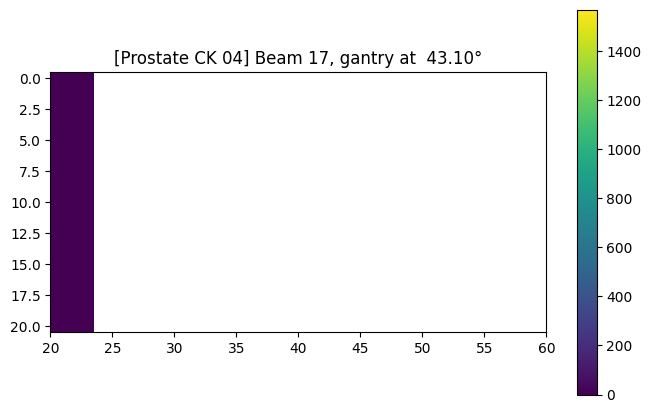

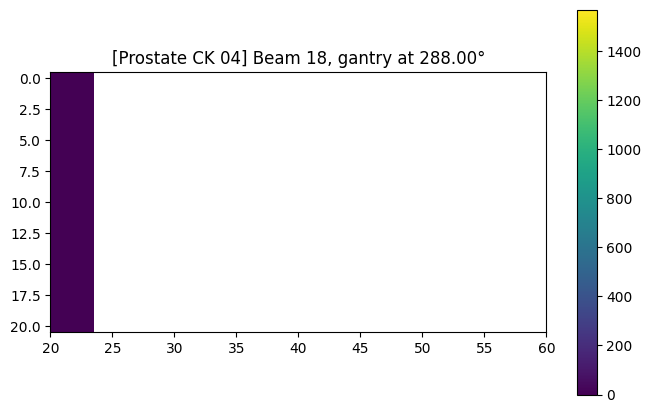

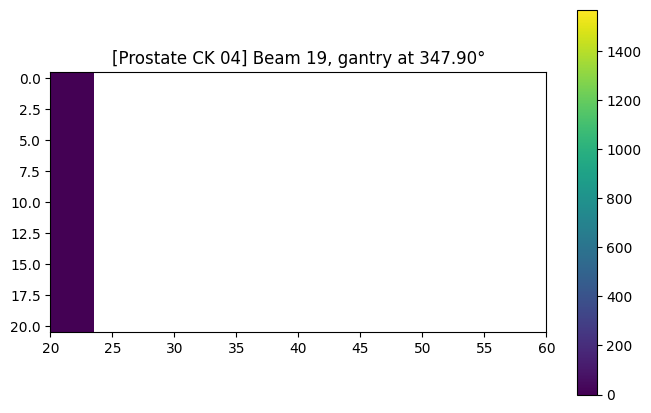

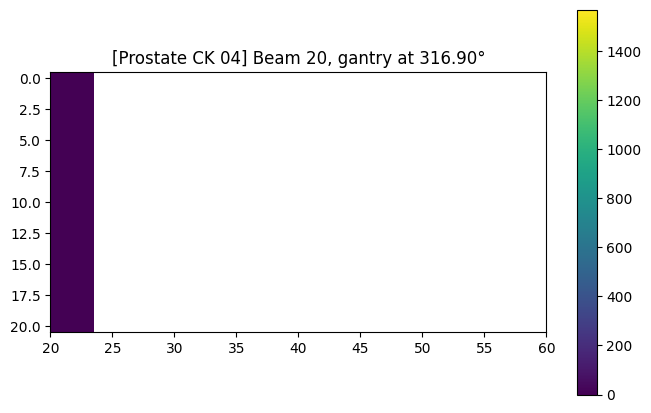

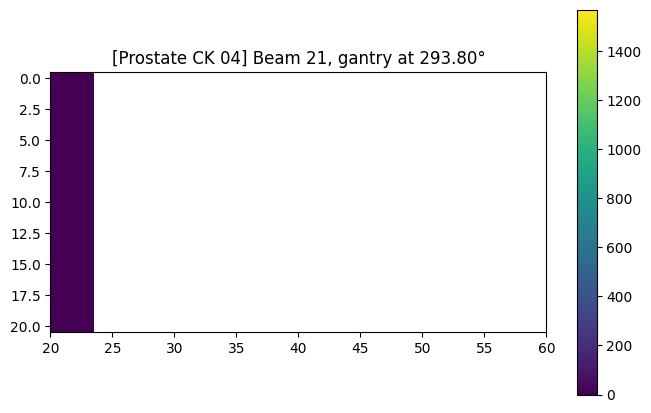

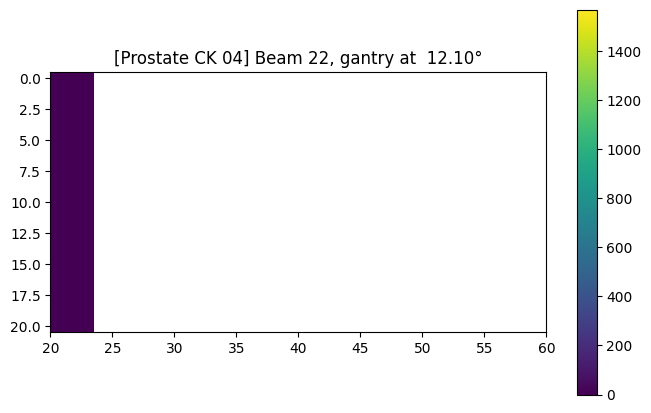

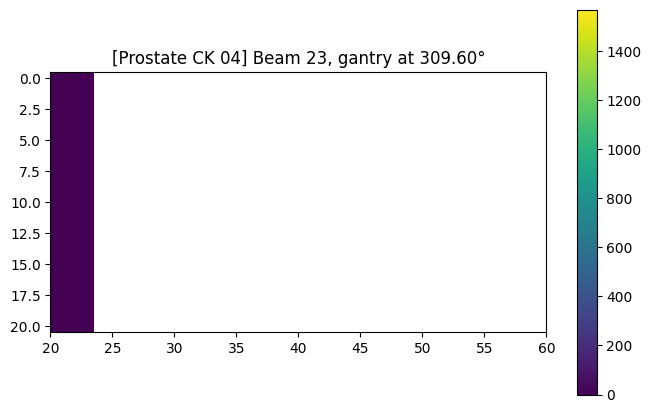

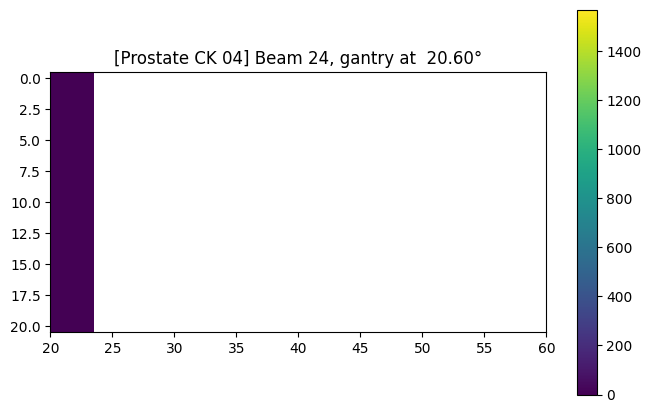

In [30]:
import matplotlib.pyplot as plt

for beam in beams:
    plt.rcParams['figure.figsize'] = [8, 5]
    plt.title(f'[{patient_name}] {beam}')
    im = plt.imshow(beam.fluence)
    plt.colorbar()
    im.set_clim(0, np.max(original_fluence))
    #plt.imshow(beam.field)
    plt.xlim(20, 60)
    plt.show()

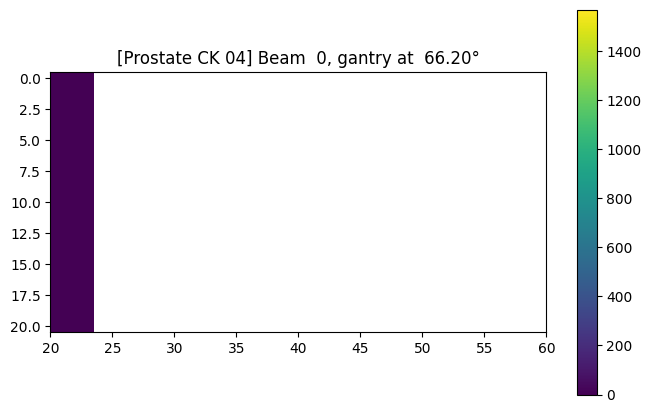

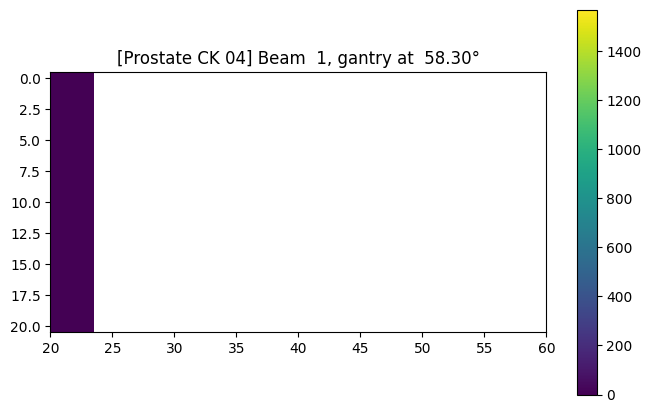

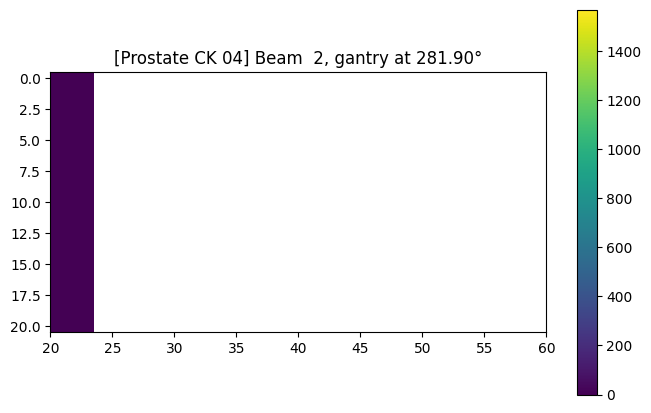

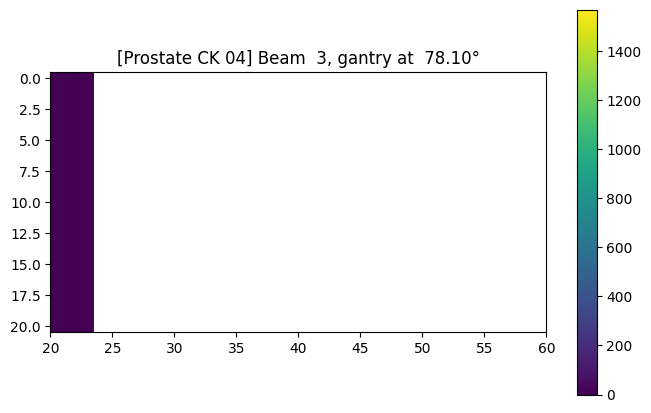

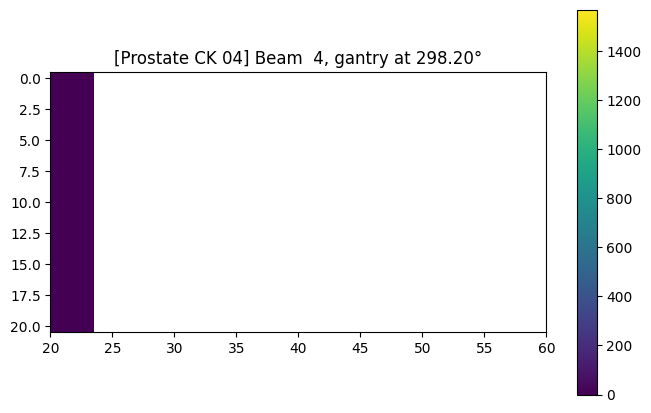

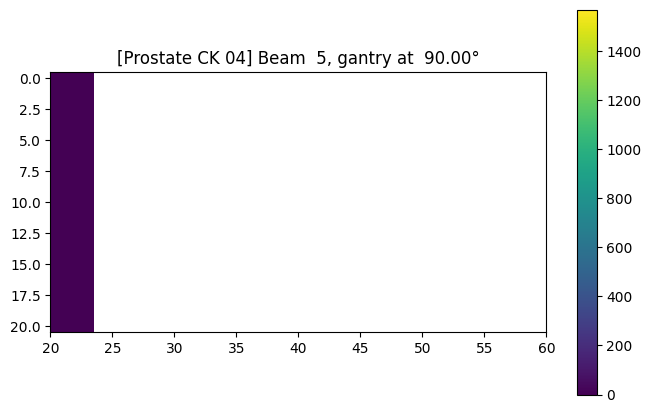

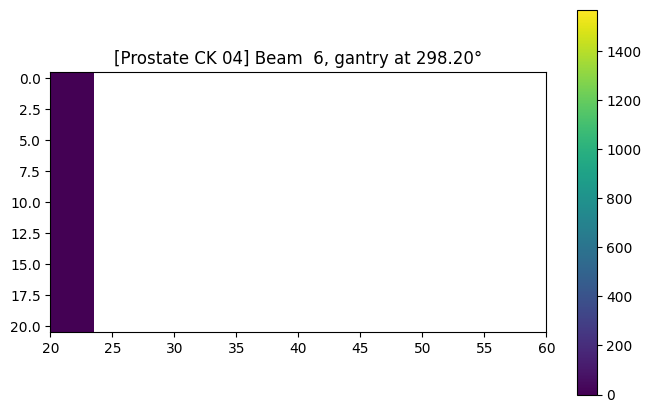

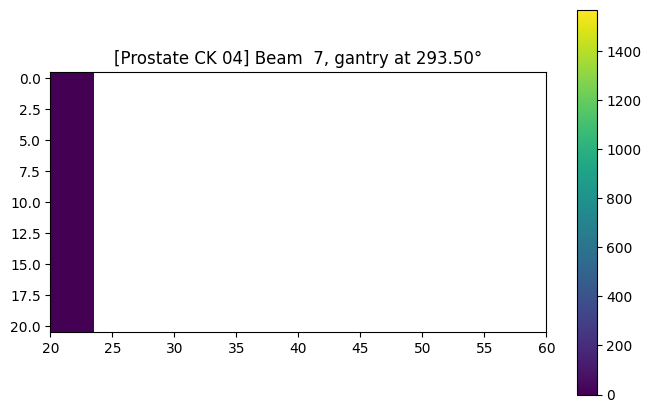

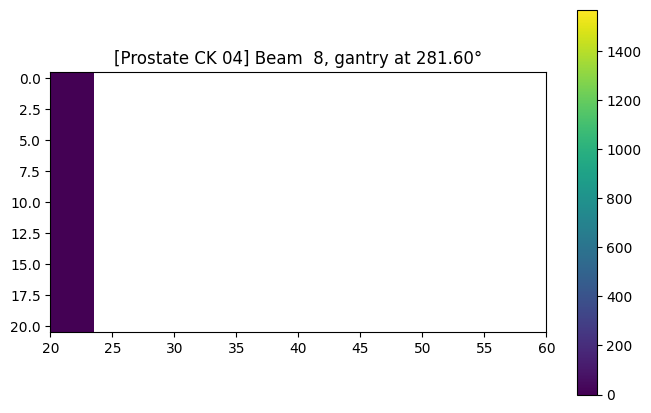

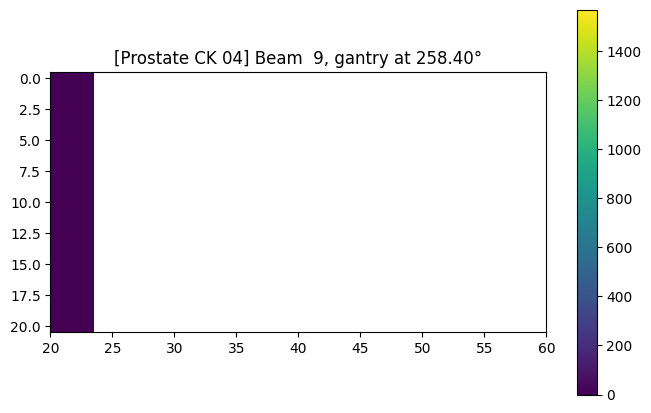

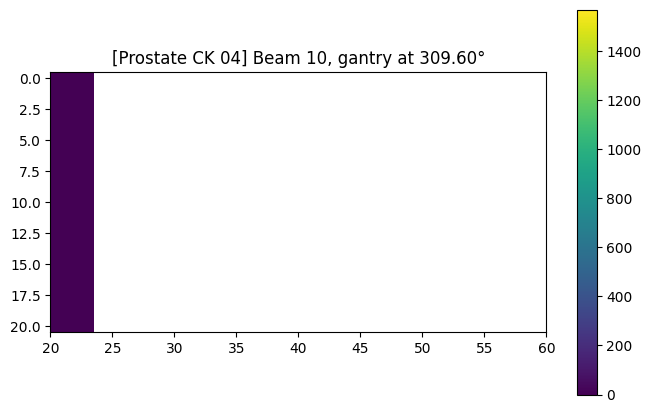

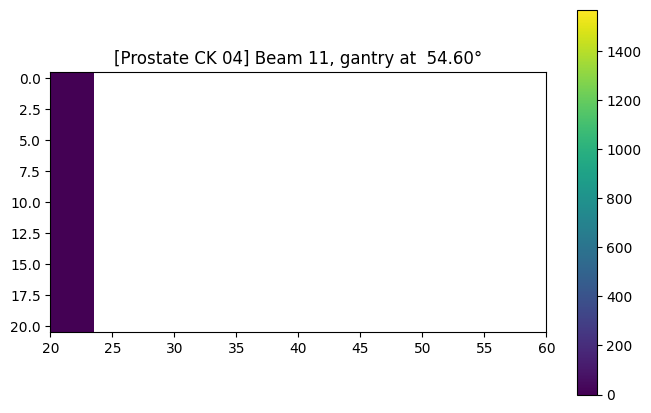

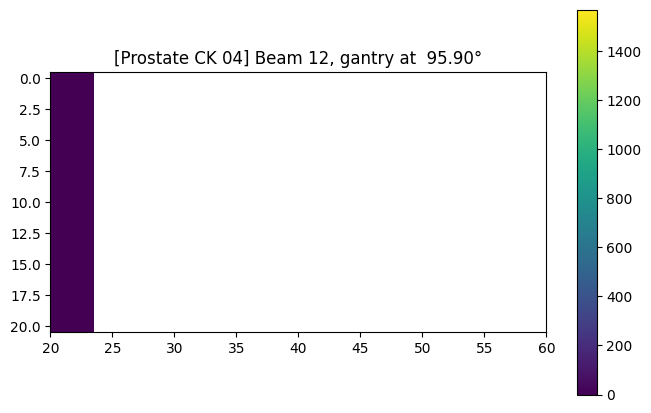

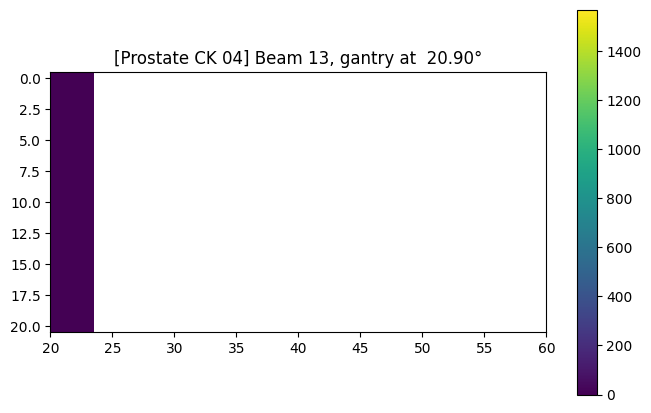

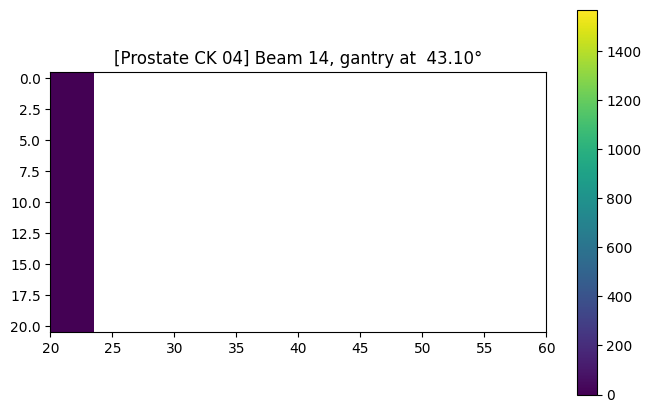

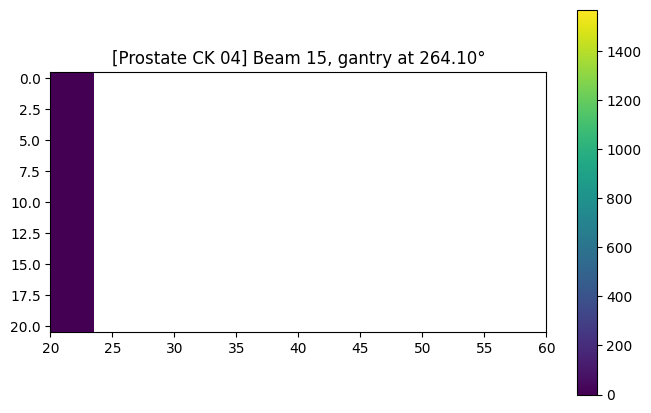

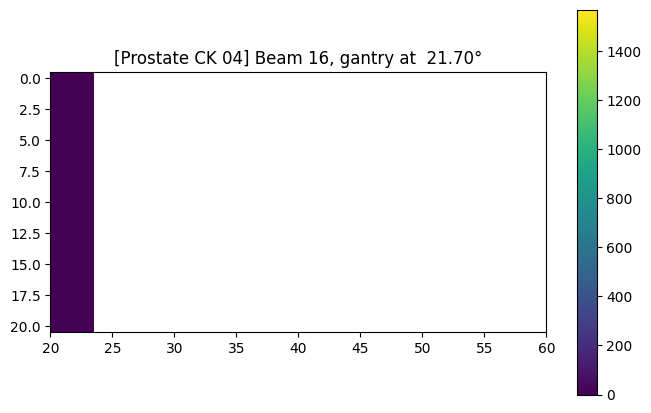

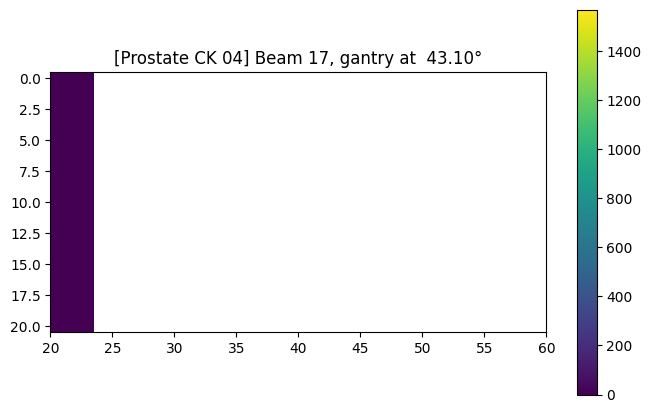

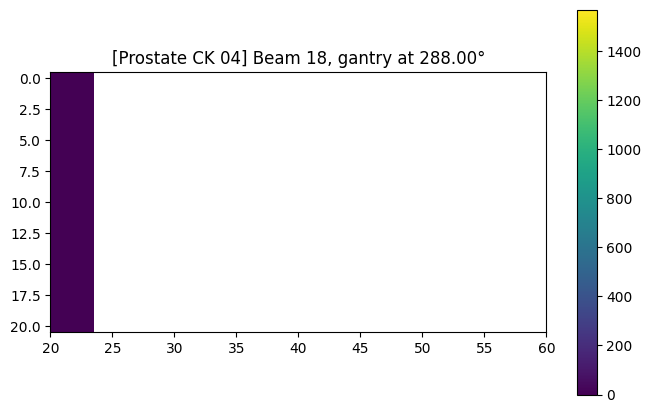

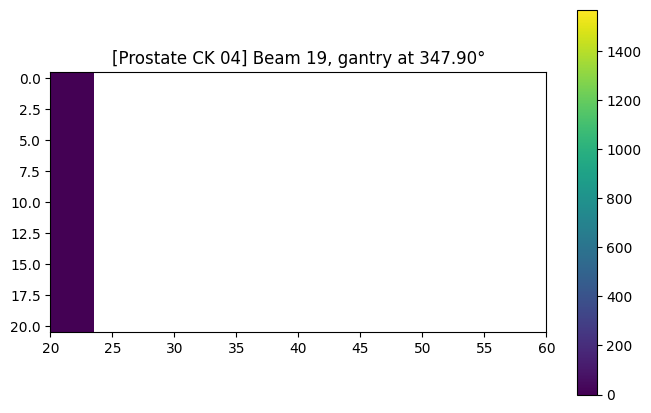

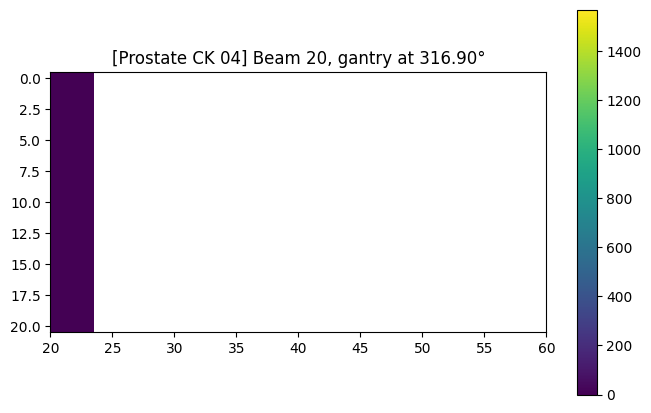

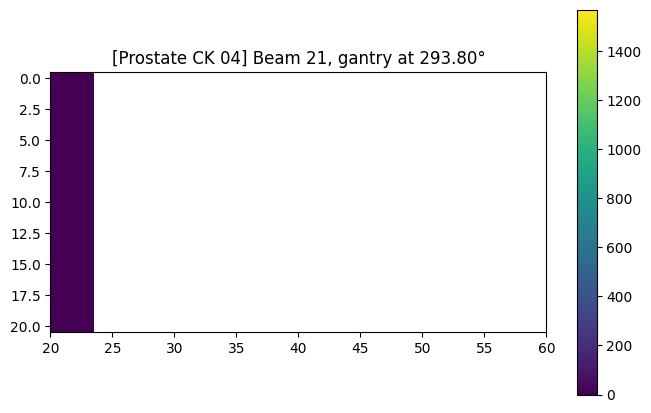

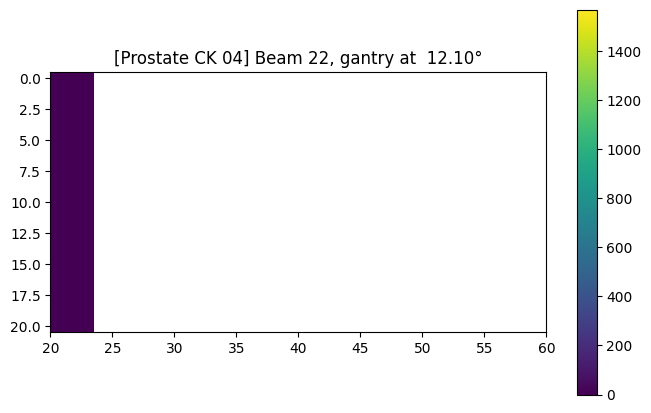

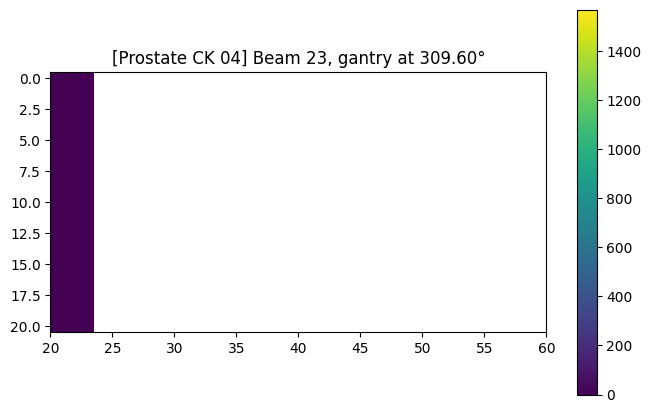

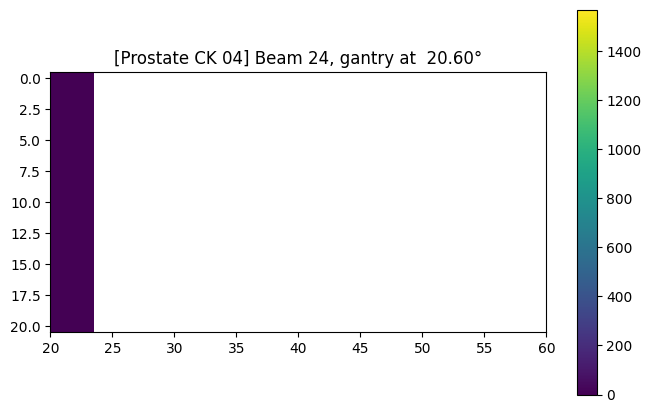

In [31]:
import matplotlib.pyplot as plt

with open('../Results/Adam/Prostate_CK_04/x_20250811_203437.txt') as file: 
    our_fluence = np.array([float(x.split()[-1]) for x in file.readlines()])

offset = 0
for beam in beams:
    beam.draw_fluence(offset, our_fluence)
    offset += beam.n_beamlets

for beam in beams:
    plt.rcParams['figure.figsize'] = [8, 5]
    plt.title(f'[{patient_name}] {beam}')
    im = plt.imshow(beam.fluence)
    plt.colorbar()
    im.set_clim(0, np.max(original_fluence))
    #plt.imshow(beam.field)
    plt.xlim(20, 60)
    plt.show()

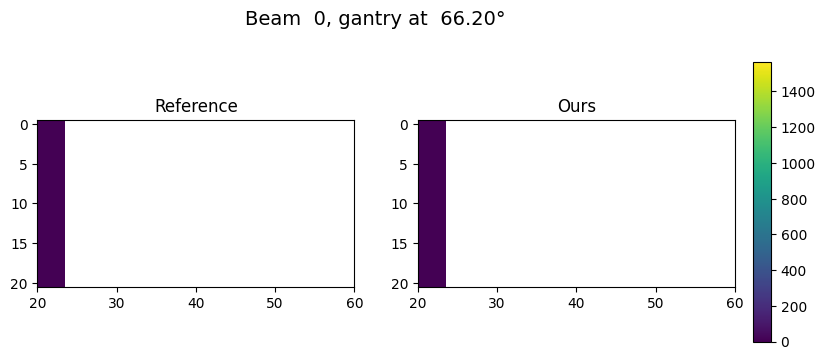

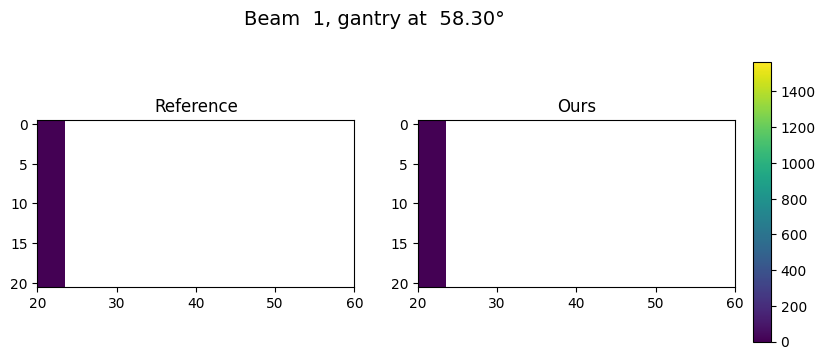

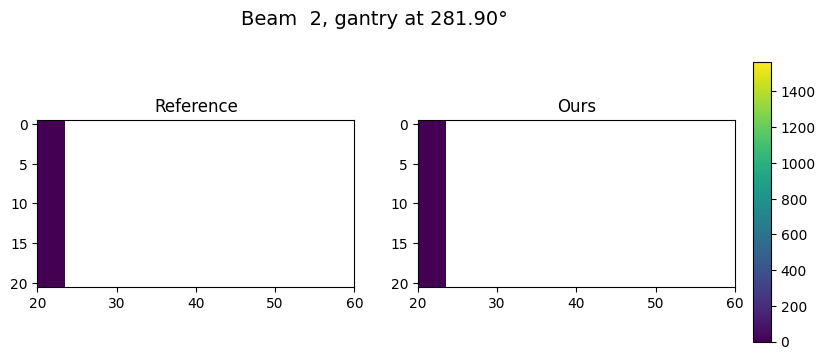

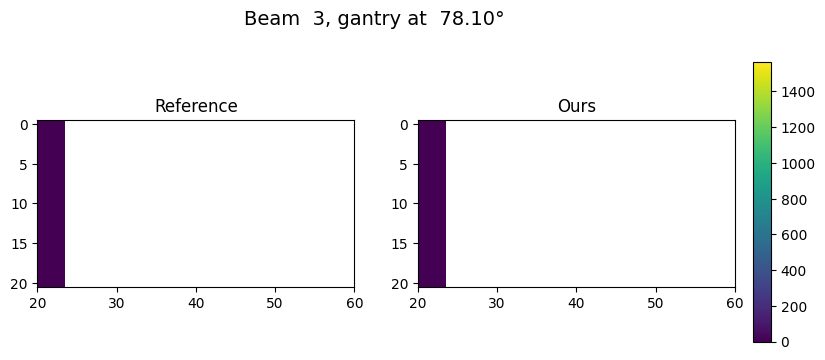

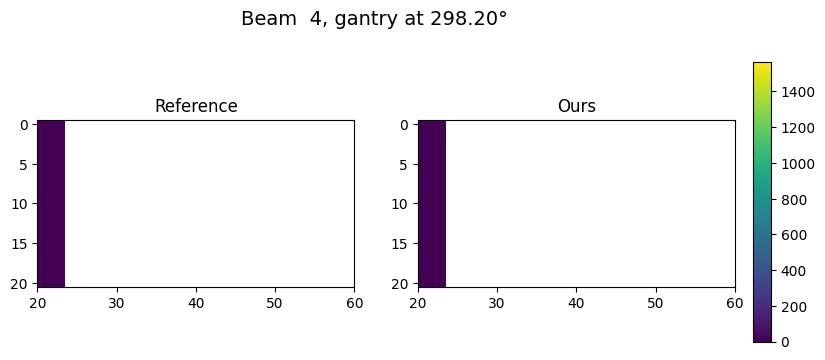

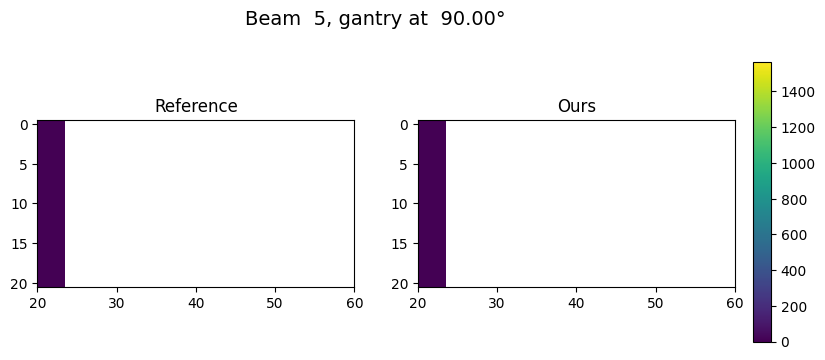

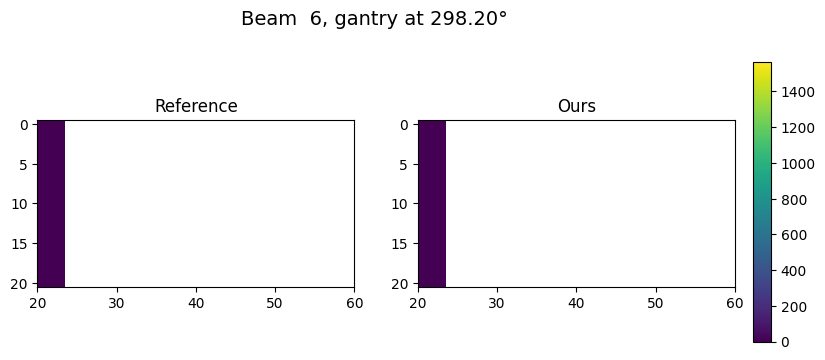

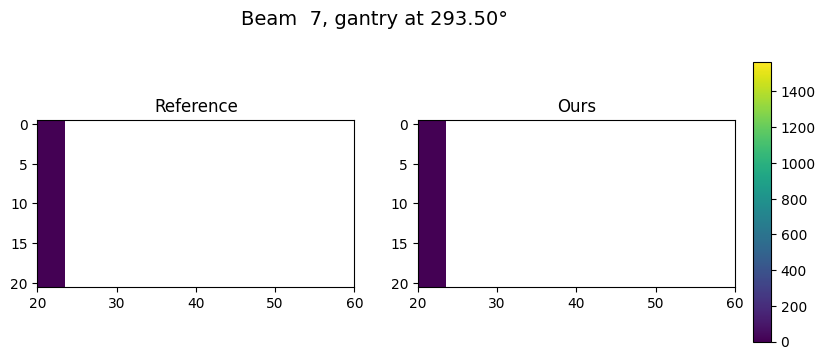

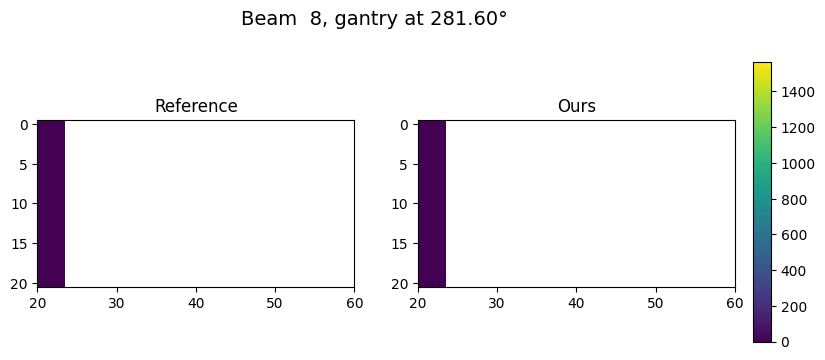

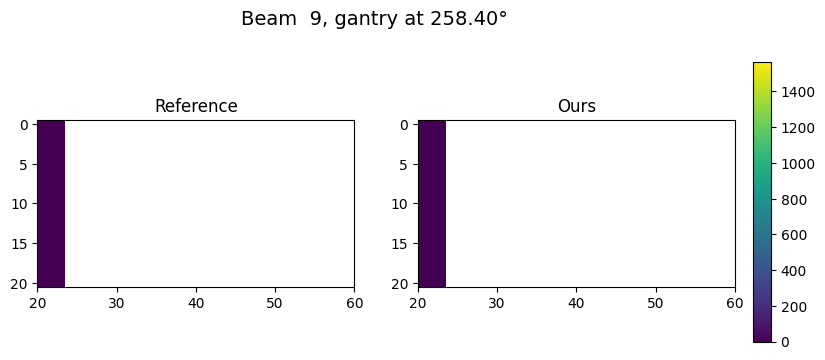

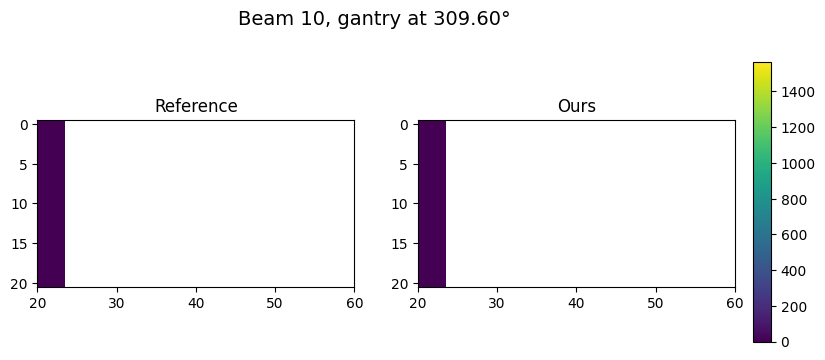

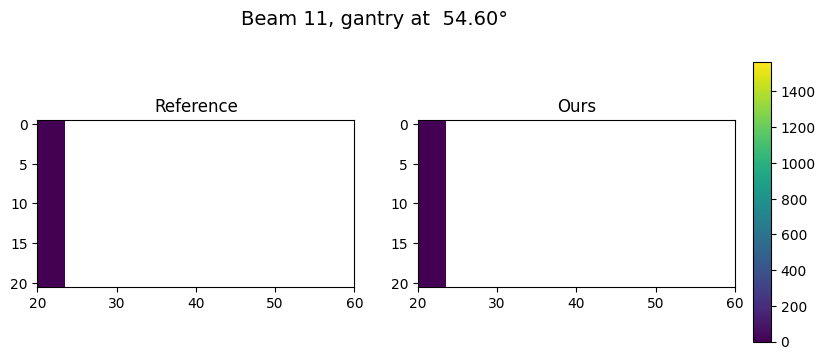

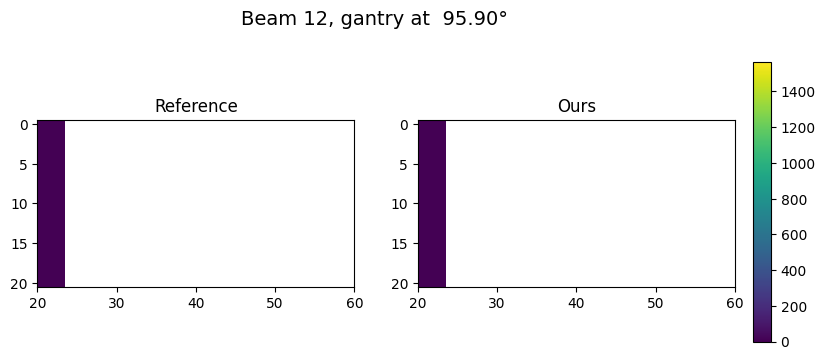

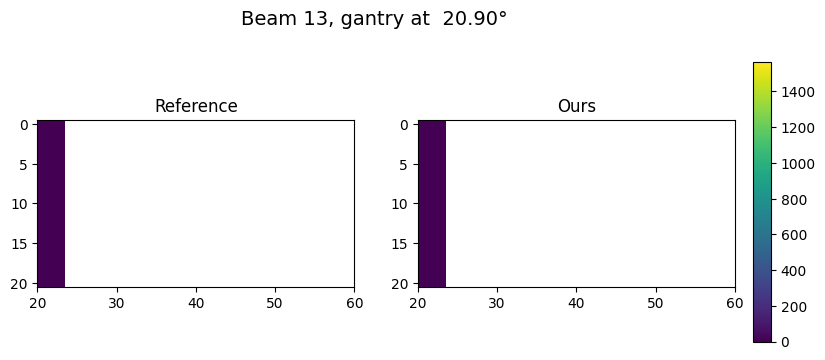

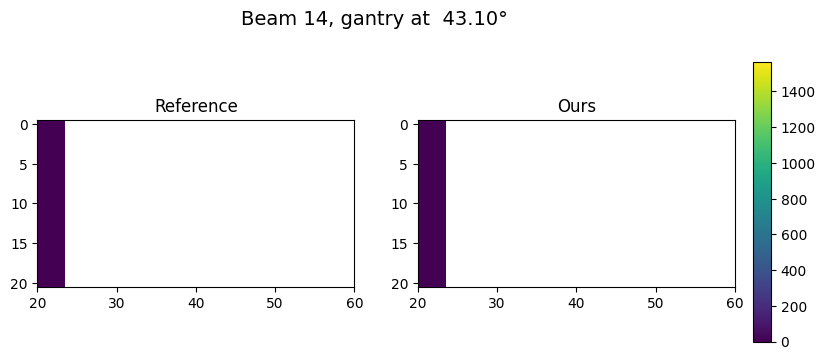

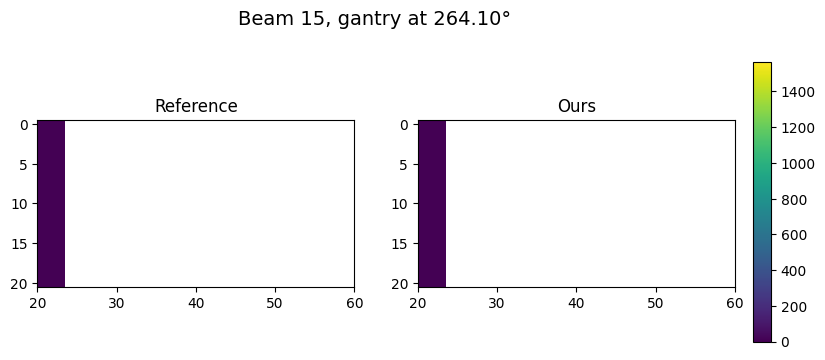

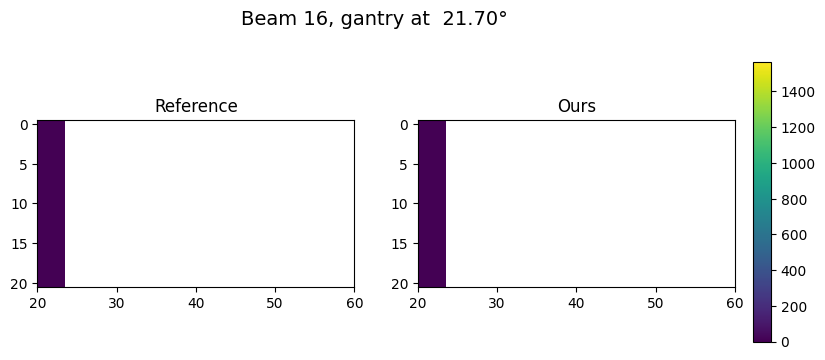

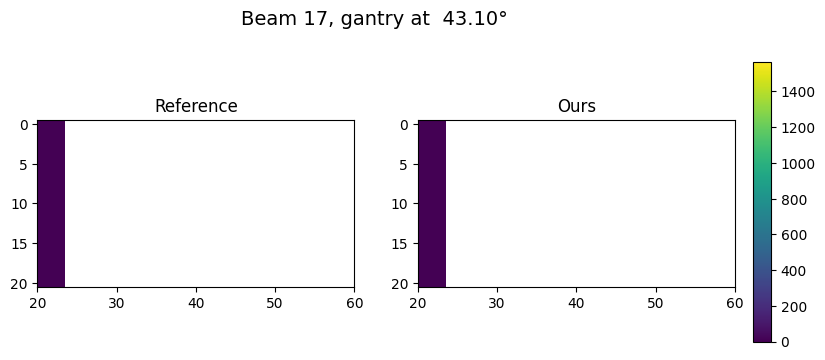

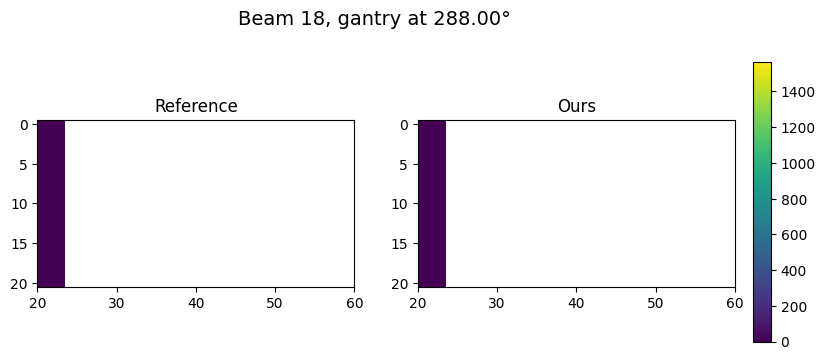

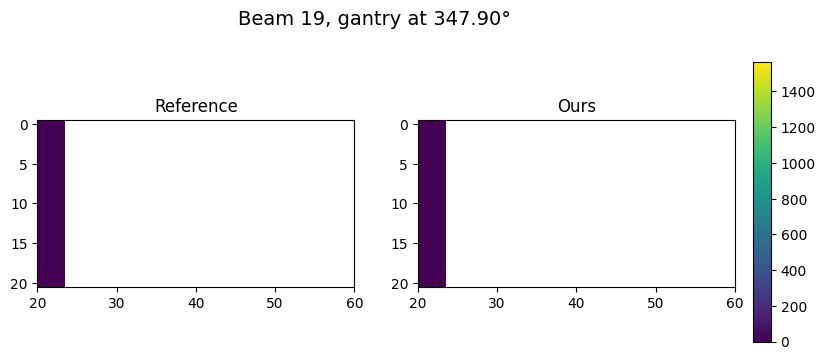

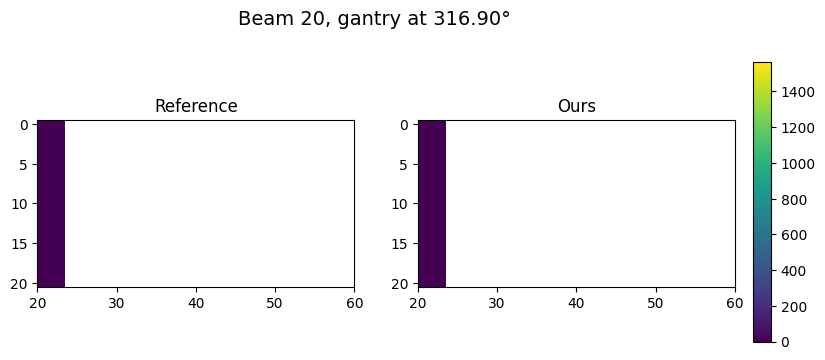

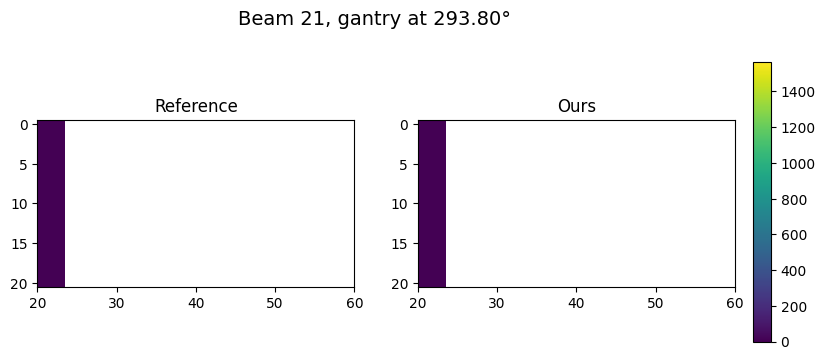

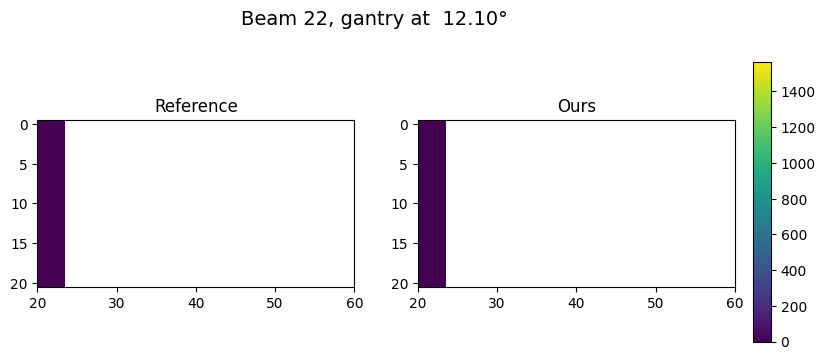

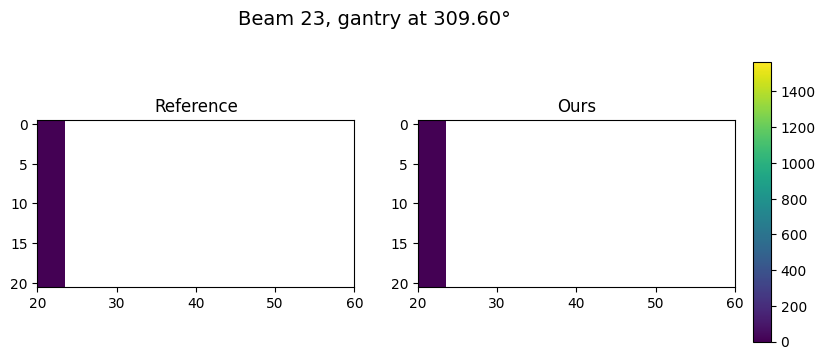

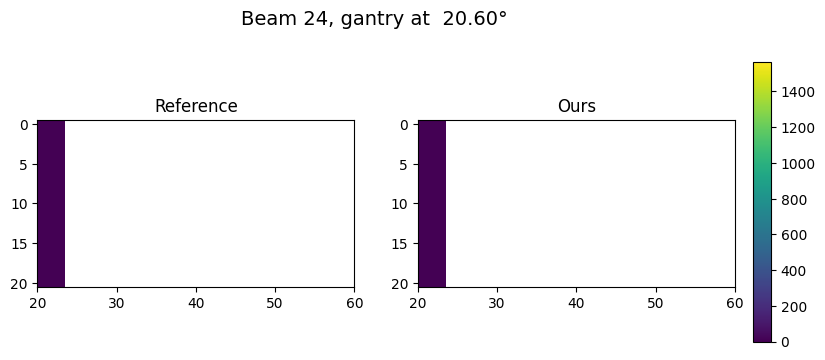

In [32]:
import matplotlib.pyplot as plt

offset = 0
for beam in beams:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

    beam.draw_fluence(offset, original_fluence)
    ax1.set_title('Reference')
    im1 = ax1.imshow(beam.fluence)
    ax1.set_xlim(20, 60)

    beam.draw_fluence(offset, our_fluence)
    ax2.set_title('Ours')
    im2 = ax2.imshow(beam.fluence)
    ax2.set_xlim(20, 60)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
    plt.colorbar(im2, cax=cbar_ax)

    im1.set_clim(0, np.max(original_fluence))
    im2.set_clim(0, np.max(original_fluence))

    plt.suptitle(f'{beam}', fontsize=14)
    # plt.savefig(f'figures/beam_{beam.i}.png')
    plt.show()

    offset += beam.n_beamlets